# Suitability of satellite sea ice thickness data for studying climate change

Production date: 28-03-2025

Produced by: Timothy Williams, Nansen Environment and Remote Sensing Center


## 🌍 Use case: Assessing the suitability of satellite sea ice thickness data for studying climate change

## ❓ Quality assessment question
**Can the effects of climate change be seen in sea ice thickness data from satellite?**

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note

- We find that the usefullness of satellite sea ice thickness data is limited for the purpose of studying climate change, since the time series are relatively short and the sea ice thickness variable has quite a lot of interannual variability. This is also the advice in the dataset documentation. However in one quite limited region a (negative) linear trend can explain a significant amount (greater than 0.5) of the variability in the data from the earlier satellite (ENVISAT, or Environmental Satellite).

- While the total sea ice volume (multiplying grid cell areas by concentration and thickness and summing) would be less variable than the thickness at each grid cell, the dataset documentation also advises against trying to compute volume from this dataset since the errors would be too great.
```

## 📋 Methodology
We consider the [sea ice thickness dataset](https://cds.climate.copernicus.eu/datasets/satellite-sea-ice-thickness?tab=overview), which has two CDR (Climate Data Record) products:
- ENVISAT CDR (2002-2010)
- CryoSat-2 CDR (2010-2020)
CryoSat-2 also has an interim CDR (ICDR, covering 2020-2024) but we did not use this product in this notebook.

We fit linear trends to these two satellite products, and assess the goodness-of-fit using the $r^2$ and $p$-value statistics.
Maps of the mean and standard deviation of the thickness, the fitted linear trend and the goodness-of-fit statistics are shown.

The "Analysis and results" section is structured as follows:

**[](section-1)**

**[](section-2)**

**[](section-3)**

## 📈 Analysis and results

(section-1)=
### 1. Parameters, requests and functions definition
- Define parameters and formulate requests for downloading with the EQC toolbox.
- Define functions to be applied to process and reduce the size of the downloaded data.
- Define functions to post-process and visualize the data.

(section-1.1)=
#### 1.1 Import libraries
Define code to import the required libraries

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot
import pandas as pd
import numpy as np
import cmocean
from collections import defaultdict

plt.style.use("seaborn-v0_8-notebook")

(section-1.2)=
#### 1.2 Set parameters
- Set the time range for ENVISAT data with `year_start_envisat` and `year_stop_envisat`
- Set the time range for CRYOSAT data with `year_start_cryosat` and `year_stop_cryosat`

In [2]:
year_start_envisat = 2002
year_stop_envisat = 2010

year_start_cryosat = 2010
year_stop_cryosat = 2020

(section-1.3)=
#### 1.3 Define requests
Define requests for downloading with the EQC toolbox.

In [3]:
collection_id = "satellite-sea-ice-thickness"

year_ranges = {
    "envisat": range(year_start_envisat, year_stop_envisat + 1),
    "cryosat_2": range(year_start_cryosat, year_stop_cryosat + 1),
}

requests = {}
for satellite, year_range in year_ranges.items():
    requests[satellite] = {
        "satellite": satellite,
        "version": "3_0",
        "cdr_type": "cdr",
        "variable": "all",
        "year": list(map(str, year_range)),
        "month": [f"{month:02d}" for month in [1, 2, 3, 4, 10, 11, 12]],
    }

chunks = {"year": 1}

#### 1.4 Define function to cache
- `monthly_weighted_linear_trend` sorts by month and calls `sea_ice_thickness_linear_trend` to get the thickness trend for each month. The p-value or RMSE may be requested to get the goodness-of-fit for the linear trend.

In [4]:
def sea_ice_thickness_linear_trend(ds, **kwargs):
    da = ds["sea_ice_thickness"]
    if not kwargs.get("p_value") and not kwargs.get("rmse"):
        return diagnostics.time_weighted_linear_trend(da, **kwargs)
    return xr.Dataset(
        diagnostics.time_weighted_linear_trend(
            da.chunk(time=-1),
            **kwargs,
        )
    )


def monthly_weighted_linear_trend(ds, **kwargs):
    return ds.groupby("time.month").apply(sea_ice_thickness_linear_trend, **kwargs)

(section-1.5)=
#### 1.5 Post-processing function
- `postprocess_dataset` tidies the coordinates and attributes of the variables, and also returns a dataset the difference with the difference between the CRYOSAT-2 and ENVISAT means.

In [5]:
def postprocess_dataset(ds):
    # reorder months to [Oct, Nov, ..., Apr] ie in order of winter
    # and put envisat before cryosat-2 (chronological order)
    month_indices = np.array([4,5,6,0,1,2,3])
    data_diff = {
        "latitude": ds["latitude"],
        "longitude": ds["longitude"],
    }
    coords_diff = {
        "month": [pd.Timestamp(2000, m.item(), 1).strftime('%B') for m in ds.month[month_indices]],
        "yc": ds.yc,
        "xc": ds.xc,
    }
    coords_orig = {"satellite": ['ENVISAT', 'CryoSat-2']} | coords_diff
    data_orig = dict(**data_diff)

    # convert trend from m/s to m/year
    unit_factors = defaultdict(lambda: 1, {"linear_trend": 365.25 * 24 * 3600})

    # attributes for variables
    attrs = {
        "mean": {
            "standard_name": "mean_sea_ice_thickness",
            "long_name": "Mean of sea ice thickness",
            "units": "m",
        },
        "std": {
            "standard_name": "standard_deviation_of_sea_ice_thickness",
            "long_name": "Standard deviation of sea ice thickness",
            "units": "m",
        },
        "linear_trend": {
            "standard_name": "linear_fit_to_sea_ice_thickness",
            "long_name": "Linear fit to sea ice thickness",
            "units": "m year$^{-1}$",
        },
        "p_value": {
            "standard_name": "p-value for linear fit to sea ice thickness",
            "long_name": "p-value for linear fit to sea ice thickness",
            "units": "",
        },
        "r2": {
            "standard_name": "r$^2$ value for linear fit to sea ice thickness",
            "long_name": "r$^2$ value for linear fit to sea ice thickness",
            "units": "",
        },
    }
    
    for vname in ds.data_vars:
        # reorder months and satellites here as well
        arr = unit_factors[vname] * ds[vname].values[::-1,month_indices,:,:]
        # set coords and attributes
        data_orig[vname] = xr.DataArray(arr, coords=coords_orig, attrs=attrs[vname])
        if vname == "mean":
            data_diff["mean_diff"] = xr.DataArray(
                arr[1] - arr[0], # cryosat-2 - envisat
                coords=coords_diff,
                attrs={
                    "standard_name": "difference_in_mean_sea_ice_thickness",
                    "long_name": "Difference in mean of sea ice thickness",
                    "units": "m",
                },
            )
        elif vname == "std":
            data_diff["std_diff"] = xr.DataArray(
                arr[1] - arr[0], # cryosat-2 - envisat
                coords=coords_diff,
                attrs={
                    "standard_name": "difference_in_std_sea_ice_thickness",
                    "long_name": "Difference in standard deviation of sea ice thickness",
                    "units": "m",
                },
            )
    clean = lambda ds, vname: ds.where(ds[vname].notnull().compute(), drop=True)
    return clean(xr.Dataset(data_orig), "mean"), clean(xr.Dataset(data_diff), "mean_diff")

(section-1.6)=
#### 1.6 Plotting functions
- `plot_maps` plots monthly maps for a given variable.
- `plot_trends` plots the trend with the goodness-of-fit statistices, the $r^2$ and $p$ values.

In [6]:
def plot_maps(da, pad=.05, shrink=.75, extend="both", **kwargs):
    kw = dict(
        projection=ccrs.Stereographic(central_latitude=90),
        robust=True,
        col="month",
    )
    if "satellite" in da.coords:
        kw["row"] = "satellite"
    facet_grid = plot.projected_map(da, cbar_kwargs={"pad" : pad, 'shrink': shrink, 'extend': extend}, **kw, **kwargs)
    facet_grid.set_titles(template="{value}")


def plot_trends(ds, satellite, month):

    ds_trend = ds.sel(month=month, satellite=satellite).drop_vars(["mean", "std", "satellite", "month"])
    kw_plot = dict(
        linear_trend = dict(cmap=cmocean.cm.balance, vmin=-.2, vmax=.2, extend="both"),
        r2 = dict(cmap="viridis", vmin=0, vmax=.5, extend="max"),
        p_value = dict(cmap="viridis", vmin=0.1, vmax=1, extend="min"),
    )
    cbar_kwargs=dict(pad=.1, shrink=.8)
    
    # Create plots
    n_vars = len(kw_plot)
    fig = plt.figure(figsize=(6 * n_vars, 4.5))
    proj = ccrs.NorthPolarStereo()
    axs = [fig.add_subplot(100 + 10 * n_vars + i + 1, projection=proj) for i in range(n_vars)]
    
    # Loop over variables
    for (vname, kw), ax in zip(kw_plot.items(), axs):
        da = ds_trend[vname]
        plot.projected_map(
            da, ax=ax,
            cbar_kwargs=cbar_kwargs | dict(extend=kw["extend"]),
            **{k: v for k,v in kw.items() if k != "extend"},
            projection=proj, show_stats=False)

    fig.suptitle(f"Linear fit to {satellite} SIT ({month})")
    fig.subplots_adjust(top=0.95, wspace=0.3)

(section-2)=
### 2. Download and transform the data
This is where the data is downloaded, transformed using `monthly_weighted_linear_trend` and saved to disk by the EQC toolbox. If the code is rerun the transformed data is loaded from the disk.
The transformed data is then post-processed by `postprocess_dataset` after downloading or loading.

In [7]:
#hide-output
funcs = (diagnostics.monthly_weighted_mean, diagnostics.monthly_weighted_std)
objects = []
for satellite, request in requests.items():
    print(f"{satellite=}")
    for func in funcs:
        _, name = func.__name__.rsplit("_", 1)
        ds = download.download_and_transform(
            collection_id,
            request,
            chunks=chunks,
            transform_chunks=False,
            transform_func=func,
            transform_func_kwargs={"weights": False},
        )
        da = ds["sea_ice_thickness"].rename(name)
        da.attrs["long_name"] = f"{name.title()} of " + da.attrs["long_name"]
        objects.append(da.expand_dims(satellite=[satellite]))

    ds = download.download_and_transform(
        collection_id,
        request,
        chunks=chunks,
        transform_chunks=False,
        transform_func=monthly_weighted_linear_trend,
        transform_func_kwargs={"weights": False, "p_value": True, "r2": True},
    )
    objects.append(ds.expand_dims(satellite=[satellite]))

ds_orig, ds_diff = postprocess_dataset(xr.merge(objects))

satellite='envisat'
satellite='cryosat_2'


(section-3)=
### 3. Results
In section [3.1](section-3.1) we plot monthly maps showing the mean and variability of sea ice thickness for the two satellites, and also plot the difference between the means for the two satellites to get an idea of the change in thickness going from the earlier to the later period.

In section [3.2](section-3.2), we compute linear trends for the two satellites and test the goodness-of-fit of the linear fit.

(section-3.1)=
#### 3.1 Temporal mean and variability, and difference between satellite periods

Below we show the mean sea ice thickness for the two satellites ENVISAT (2002-2010) and CryoSat-2 (2010-2020), along with the difference between them.
The thickness in the CryoSat-2 product is higher at the coast north of Greenland and Canada and this extends to around the North Pole in earlier winter and a bit further later in the winter.
This pattern is consistent with the pattern in the ENVISAT thickness, but much of the area of interest is obscured by the large polar hole in that product.
However, looking at the difference in the means, there is a slight drop in thickness in the overlapping areas of thicker ice.
In general the mean thickness has dropped, with the exception of the area north of the Canadian archipelago (adjacent to the overlapping area of thicker ice) and in the Greenland Sea in the later winter months.

The two satellites have different biases (CryoSat-2 has a slight positive bias, while ENVISAT has a more significant negative bias) and accuracies so we should be be a little careful when comparing and trying to deduce temporal changes between them.
Given the satellite biases we can trust the reductions in thickness more than the increases in thickness. Moreover the increases in thickness also occur in regions of higher variability (plotted after the means and the difference in the means). Having said this we have used an 8-10 year averaging period so some of the variability will have been smoothed out.

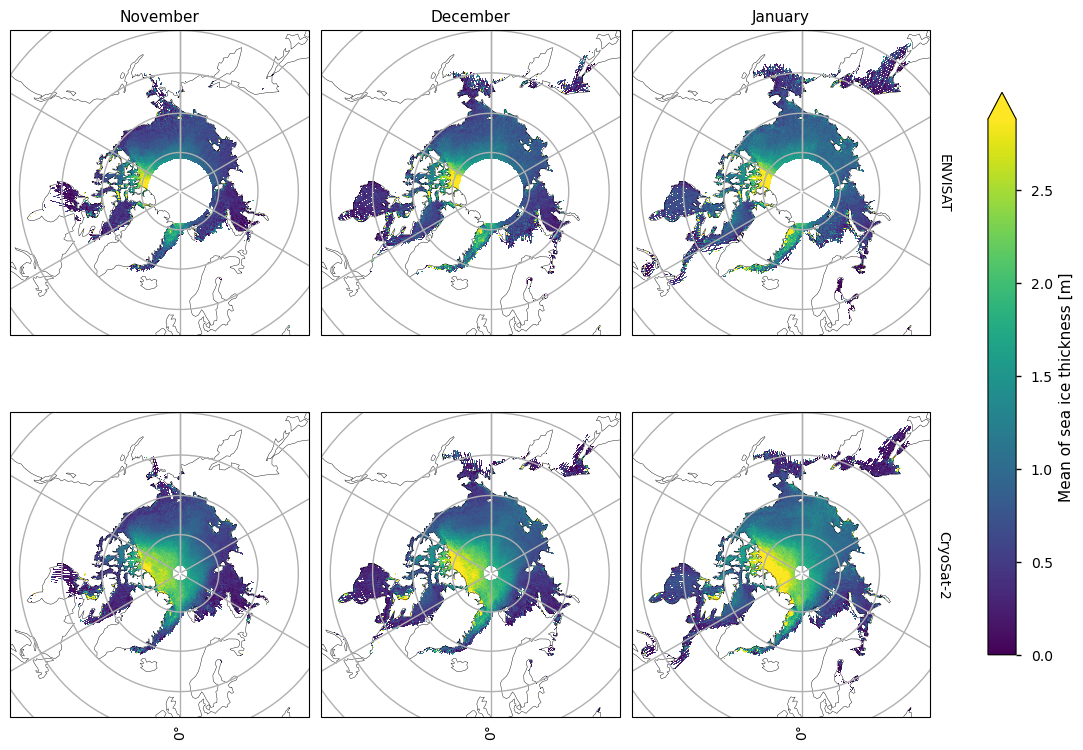

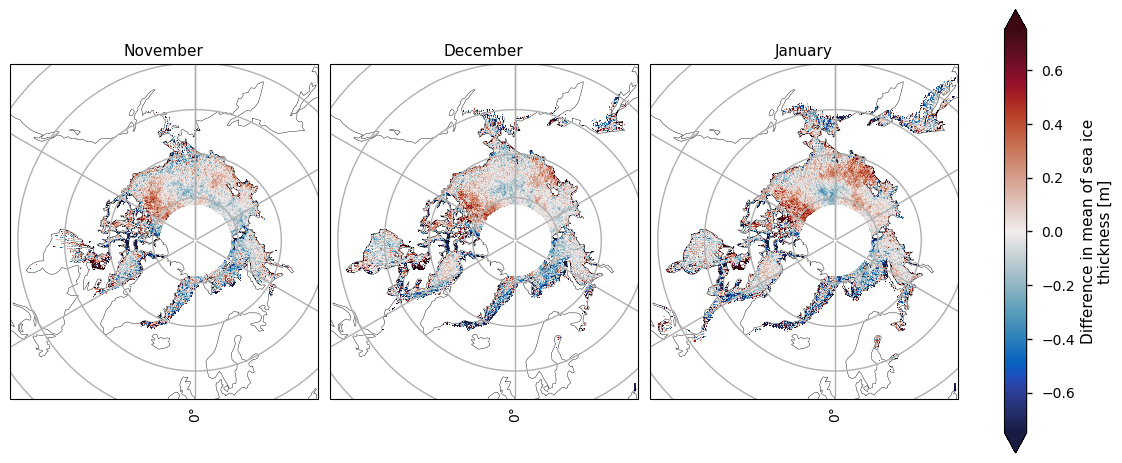

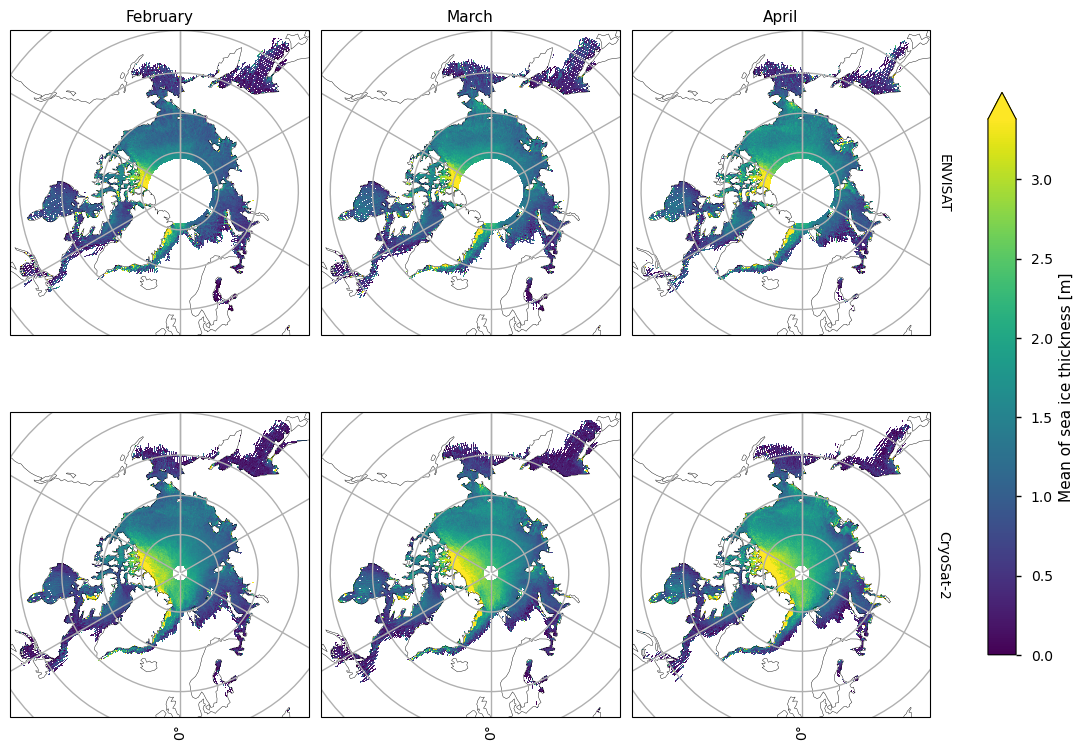

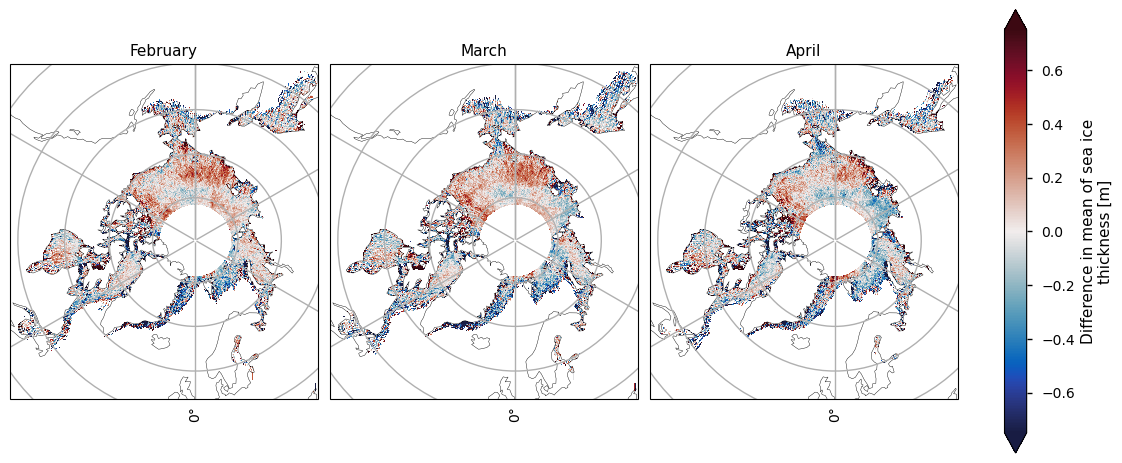

In [23]:
kw_mean = dict(vmin=0, extend="max")
kw_diff = dict(vmin=-.75, vmax=.75, pad=.04, shrink=1.25, cmap=cmocean.cm.balance)
month_sets = [
    ["November", "December", "January"],
    ["February", "March", "April"],
]
size_ratio = 4
for months in month_sets:
    size = size_ratio * len(months)
    plot_maps(ds_orig["mean"].sel(month=months), **kw_mean, figsize=(size, 2 * size_ratio))
    plot_maps(ds_diff["mean_diff"].sel(month=months), **kw_diff, figsize=(size, size_ratio))

Below we plot the standard deviations of the two satellite periods, and also the differences between them. Looking at the CryoSat-2 plots, the variability is roughly correlated with thickness, but there is also high variability in the Greenland Sea due to the highly dynamic nature of that area (the ice flows quite fast once it is exported through the Fram Strait). Looking at the differences, the variability has generally increased, with the exception of the area between the Beaufort Sea and the ENVISAT polar hole. There is also less variability in the Hudson bay from January to April.

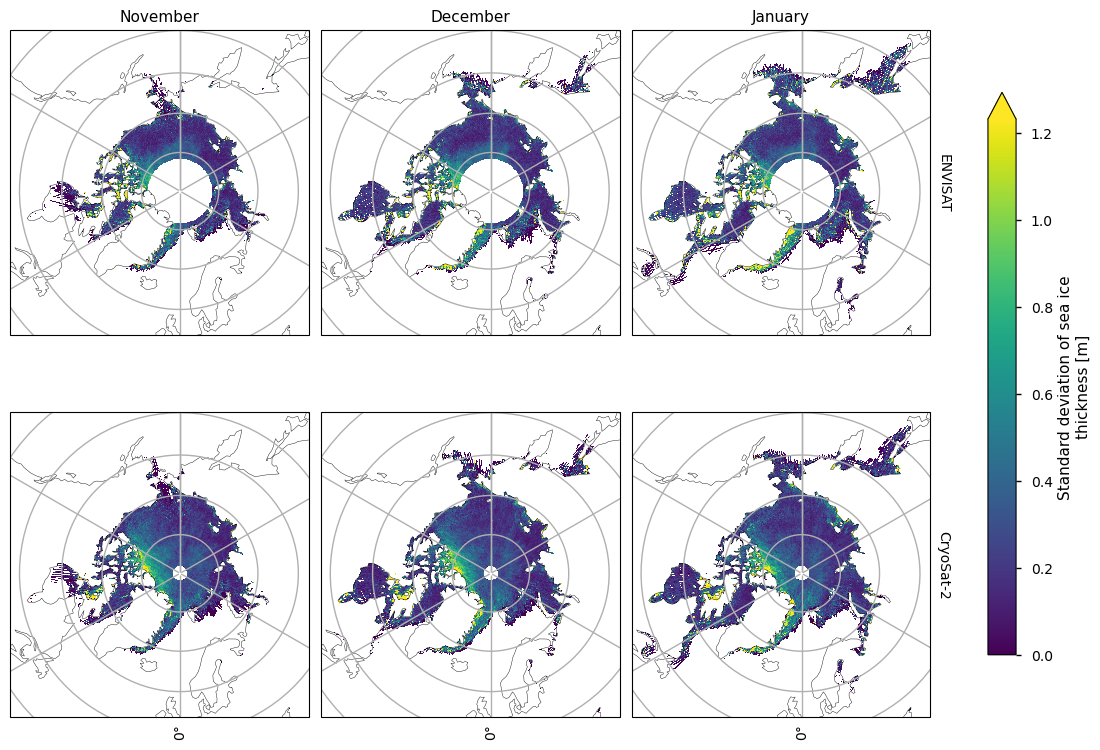

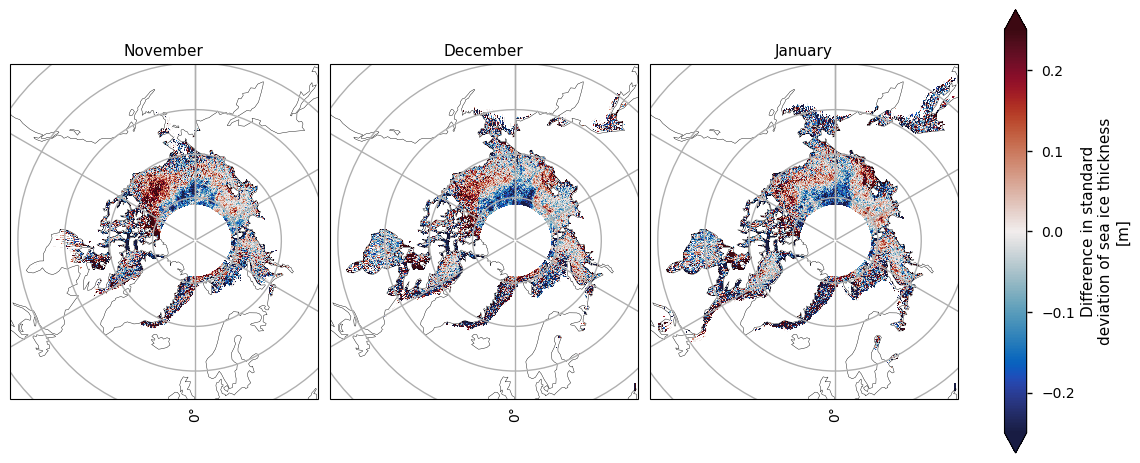

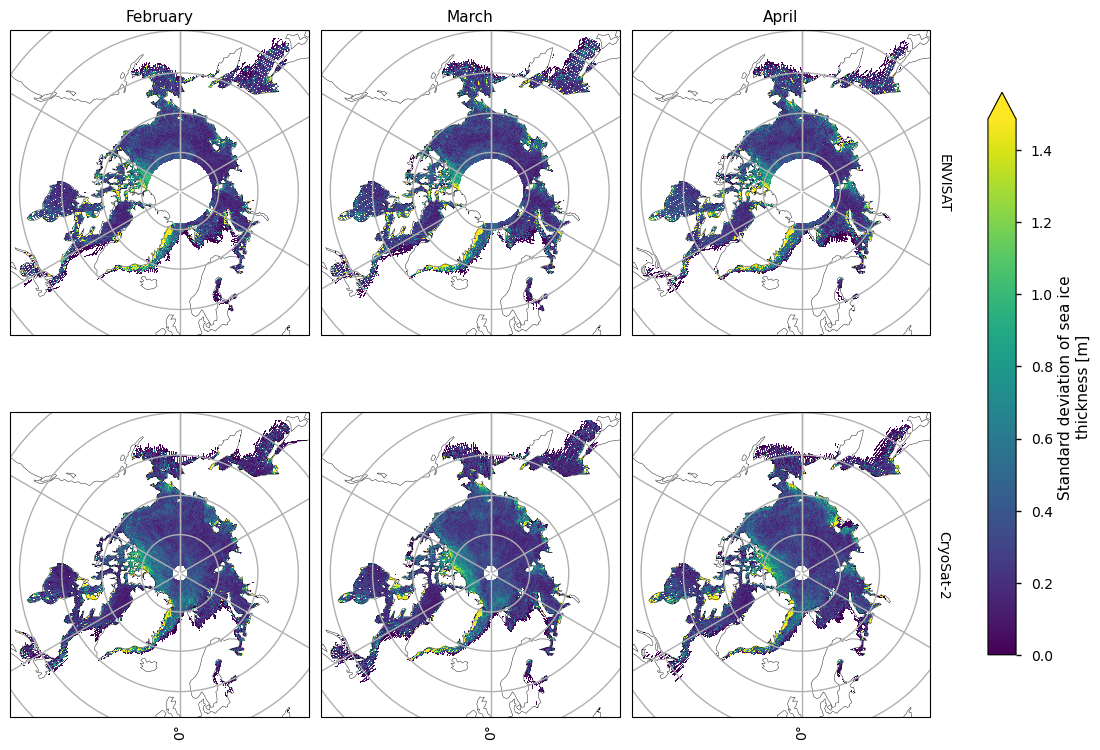

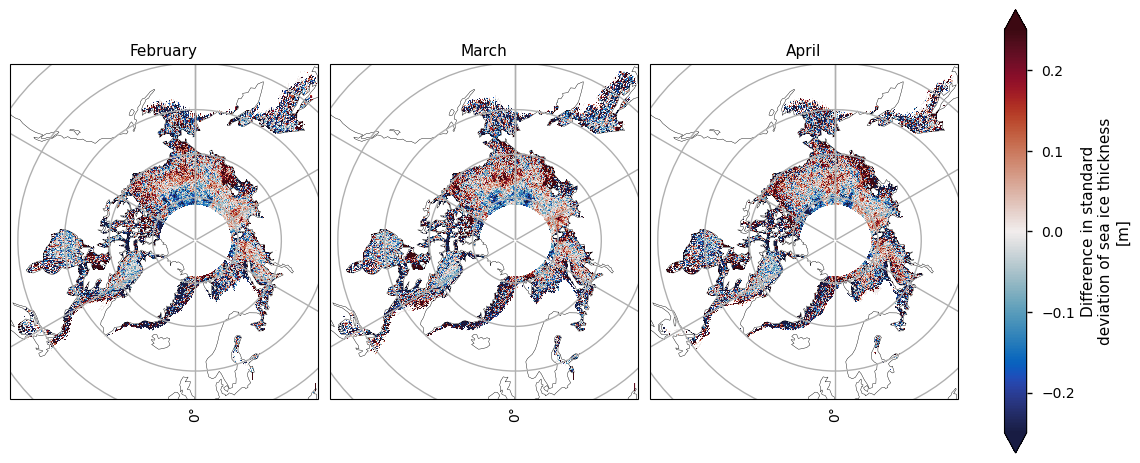

In [24]:
kw_std = dict(vmax=.75, extend="max")
kw_diff = dict(vmin=-.25, vmax=.25, pad=.04, shrink=1.25, cmap=cmocean.cm.balance)
for months in month_sets:
    size = size_ratio * len(months)
    plot_maps(ds_orig["std"].sel(month=months), **kw_mean, figsize=(size, 2 * size_ratio))
    plot_maps(ds_diff["std_diff"].sel(month=months), **kw_diff, figsize=(size, size_ratio))

(section-3.2)=
#### 3.2 Assessment of linear model for temporal variability

For both satellite periods, we calcuated linear trends in sea ice thickness along with the goodness-of-fit statistices, the $r^2$ and $p$ values. The $r^2$ statistic measures the fraction of the variability explained by the linear trends and it is generally quite low, with the exception of a region between the Beaufort Sea and the polar hole in the ENVISAT data. This region also had the most significant reduction in sea ice variability. The $p$-value gives the probability of the data being explained by random variability around a zero trend. It tells a similar story to the $r^2$-value, in that it is generally quite high, with the exception of the same region in the ENVISAT data that had the higher r$^2$ value.

Below we plot the trend in the ENVISAT data for the month of January, along with the $r^2$ and $p$ values. The trend is about -10 cm/year in the region where the fit is acceptable. Other months are similar, in both the values and the region where the fit is acceptable. However, in general the linear fit to this data is explaining very little of the temporal variability.

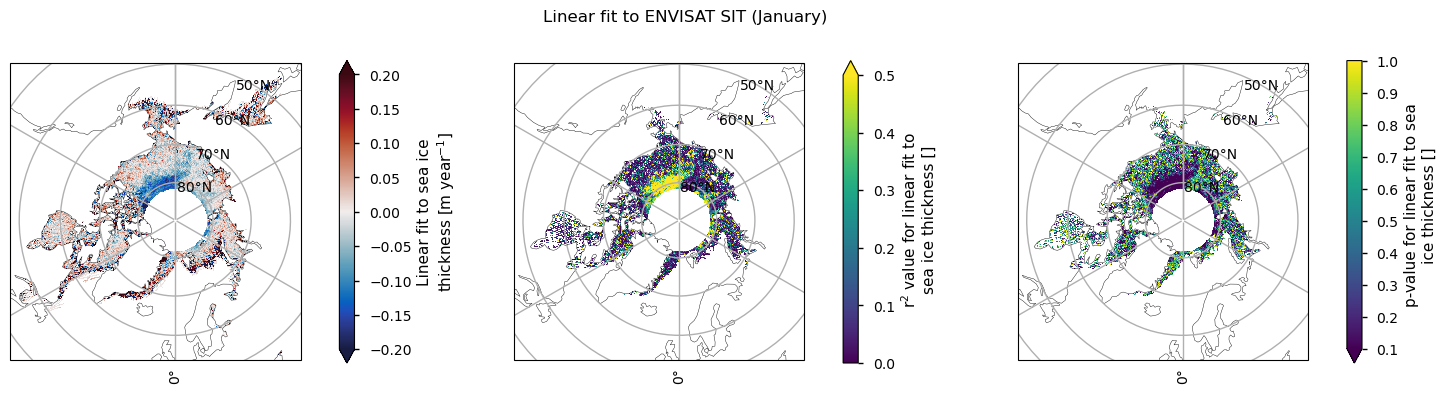

In [16]:
plot_trends(ds_orig, "ENVISAT", "January")

To illustrate the low quality of a linear fit to the CryoSat-2 data, we also repeat the above plot for that satellite. There is a very small region (the region is even smaller for other months) where the $r^2$ is reaching 0.5 and where the $p$ value is below 0.1, but in general the linear fit to this data is explaining very little of the temporal variability.

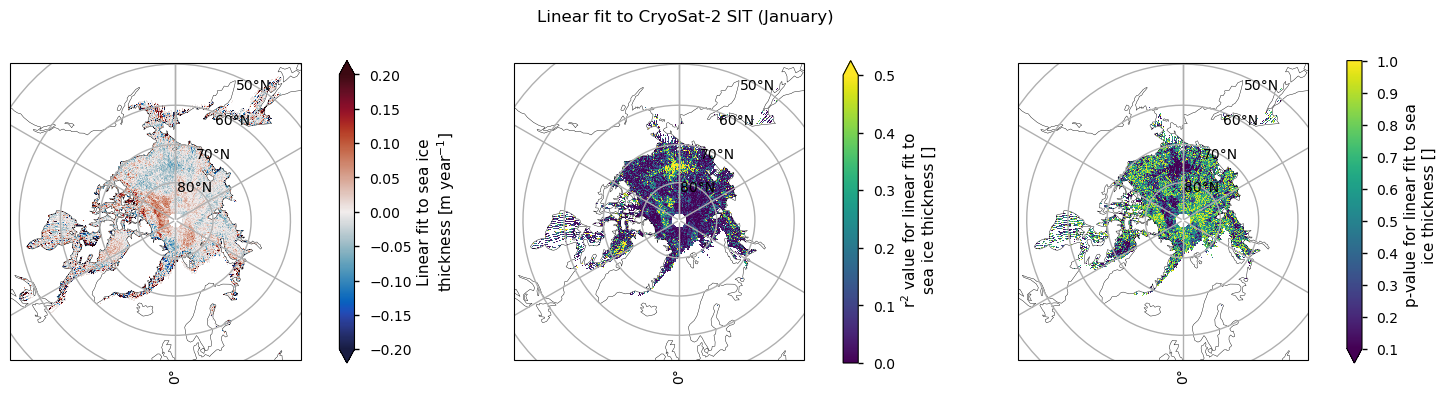

In [17]:
plot_trends(ds_orig, "CryoSat-2", "January")

## ℹ️ If you want to know more

### Key resources

Introductory sea ice materials:
- [Role of sea ice in the climate](https://www.epa.gov/climate-indicators/climate-change-indicators-arctic-sea-ice)
- [Observing sea ice with satellites](https://www.metoffice.gov.uk/research/climate/cryosphere-oceans/sea-ice/measure)

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]](https://www.sciencedirect.com/science/article/pii/S0273117717307901) Tilling, R. L., Ridout, A., & Shepherd, A. (2018). Estimating Arctic sea ice thickness and volume using CryoSat-2 radar altimeter data. Advances in Space Research, 62(6), 1203-1225.

[[2]](https://tc.copernicus.org/articles/17/809/2023/tc-17-809-2023.html) Müller, F. L., Paul, S., Hendricks, S., and Dettmering, D. (2023). Monitoring Arctic thin ice: a comparison between CryoSat-2 SAR altimetry data and MODIS thermal-infrared imagery. The Cryosphere, 17, 809–825.